In [1]:
%matplotlib inline

In [2]:
import matplotlib.cm as cm

### Grab a random latin hypercube grid of $U(\beta_{\rm early})$, $U(\beta_{\rm late})$ and $U(\log_{10}\tau_{\rm c})$

In [3]:
from conc_pop_model import get_u_param_grids
N_GRID = 250
u_be_grid, u_lgtc_bl_grid = get_u_param_grids(N_GRID)

### Calculate the PDF weight associated with each grid point and each value of $p_{50\%}$

In [4]:
from conc_pop_model import DEFAULT_PARAMS, get_pdf_weights_on_grid
from diffprof.nfw_evolution import DEFAULT_CONC_PARAMS

conc_k = DEFAULT_CONC_PARAMS['conc_k']
params_p50 = np.array(list(DEFAULT_PARAMS.values()))

N_P50 = 25
p50_arr = np.linspace(0.1, 0.9, N_P50)

_res = get_pdf_weights_on_grid(p50_arr, u_be_grid, u_lgtc_bl_grid, conc_k, params_p50)
u_be_weights, u_lgtc_bl_weights = _res

print(u_be_weights.shape, u_lgtc_bl_weights.shape)

(250, 25) (250, 25)


### Generate a prediction for ${\rm conc}(t)$ for each point on the grid and each value of $p_{50\%}$

In [5]:
from conc_pop_model import lgc_pop_vs_lgt_and_p50, get_param_grids_from_u_param_grids
N_TIMES = 60
tarr = np.linspace(2, 13.8, N_TIMES)
lgtarr = np.log10(tarr)
be_grid, lgtc_bl_grid = get_param_grids_from_u_param_grids(u_be_grid, u_lgtc_bl_grid)
_res = lgc_pop_vs_lgt_and_p50(lgtarr, p50_arr, be_grid, lgtc_bl_grid, conc_k)
lgc_p50_pop = _res
print(lgc_p50_pop.shape)

(250, 25, 60)


### Calculate $\langle{\rm conc}(t)\vert p_{50\%}\rangle$ as the PDF-weighted sum

In [6]:
avg_log_conc_p50 = np.sum(u_be_weights.reshape((N_GRID, N_P50, 1))*lgc_p50_pop, axis=0)
avg_log_conc_p50.shape

(25, 60)

### Plot the results

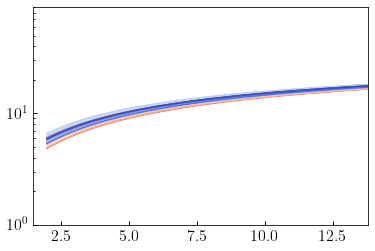

In [7]:
colormap_seq=np.linspace(1, 0, N_P50)
colors=cm.coolwarm(colormap_seq)


fig, ax = plt.subplots(1, 1)
yscale = ax.set_yscale('log')
ylim = ax.set_ylim(1, 90)
xlim = ax.set_xlim(1.5, 13.8)
for ip50 in range(N_P50):
    __=ax.plot(tarr, 10**avg_log_conc_p50[ip50, :], color=colors[ip50])

### Hmmm...

There is very little, if any, $p_{50\%}-$dependence that shows up in that plot. This _could_ just mean that the model parameters are poorly tuned (which is my guess), or it could mean there is a bug somewhere, I haven't had a chance to do more testing. For now I would proceed with next steps with existing code, but just remember that there could be some more digging to do here to finish the single-mass implementation.

## Next steps

### Step 1
For starters, in order to make sure everything is working correctly, pick a single mass and use gradient descent to fit the parameters of this model to capture the usual summary statistics:
1. $\langle{\rm log_{10}(conc(t))}\vert p_{50\%},M_0\rangle$
2. $\langle{\rm log_{10}(conc(t))}\vert M_0\rangle$
3. $\sigma({\rm log_{10}(conc(t))}\vert M_0)$

Calculating (1) is demonstrated above in this notebook. You will calculate (2) by averaging over $p_{50\%}$. You will calculate (3) by _first_ squaring the result of (2), and then in a separate step, calculating $\langle{\rm log_{10}(conc(t))^{2}}\vert M_0\rangle$, and then finally taking the square root of their difference. See the ${\tt diffmah}$ source code for an example of how to differentiably compute the stddev of a logarithmic variable, which for you is $x={\rm log_{10}(conc(t))},$ whereas in ${\tt diffmah}$ was $x=\log_{10}(M_{\rm halo}(t)).$

When you do the fitting, for your target data try using the target data model function, hopefully it will be less noisy than the actual simulated data. Try and use the "batch-training" trick we discussed on slack, such that for each step of the gradient descent, generate some new target data based on a newly generated array of grid parameters and $p_{50\%$ values. The notebook I shared with you on Slack shows how to do this using a latin hypercube to randomly generate the arrays. Repeat this exercise for a few different values of $M_0$ and verify that the differentiable model has been formulated with sufficient flexibility to give an accurate approximation.

### Step 2
Once you have a working differentiable version of the single-mass model, then it will be time to adapt the code to build a differentiable mass-dependent model. When you train the model, again use the batch-training tricks, this time selecting different parameter grids and different $p_{50\%}$ and different $M_0$ grids each time. Once you have an accurate fit of the population-level model across $M_0$ and $p_{50\%},$ that will be the principal result of the project and it will be time to write up the results and submit for publication.